In [1]:
from legal_eval.data import download_data, get_hf_dataset, parse_to_ner
from pathlib import Path

DATA_PATH = Path("../data")

%load_ext autoreload
%autoreload 2

download_data(DATA_PATH)
dataset = get_hf_dataset(DATA_PATH)
dataset_ner = parse_to_ner(dataset) 

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to D:/hf_datasets/json/default-9acc4922681c4d90/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to D:/hf_datasets/json/default-8e94a40253265d68/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/10995 [00:00<?, ? examples/s]

Map:   0%|          | 0/1074 [00:00<?, ? examples/s]

Map:   0%|          | 0/10995 [00:00<?, ? examples/s]

Map:   0%|          | 0/1074 [00:00<?, ? examples/s]

In [2]:
from legal_eval.baselines import TurboSimpleBaseline, MLBaseline
from legal_eval.utils import print_predictions, evaluate_nerlegal
import fasttext
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import numpy as np

In [3]:
baseline1 = TurboSimpleBaseline()
baseline1.fit(dataset_ner['train'])

In [4]:
evaluate_nerlegal(dataset_ner['test'], baseline1)

Map:   0%|          | 0/1074 [00:00<?, ? examples/s]

,CASE_NUMBER,COURT,DATE,GPE,JUDGE,LAWYER,ORG,OTHER_PERSON,PETITIONER,PRECEDENT,PROVISION,RESPONDENT,STATUTE,WITNESS,overall_precision,overall_recall,overall_f1,overall_accuracy,total_time_in_seconds,samples_per_second,latency_in_seconds
precision,0.0,0.000483,0.005535,0.037037,0.093458,0.054054,0.003307,0.027755,0.0,0.0,0.012730,0.004963,0.020853,0.007246,0.007369,0.057106,0.013053,0.441148,0.228171,4706.998132,0.000212
recall,0.0,0.003378,0.041860,0.019608,0.058824,0.023810,0.196203,0.129278,0.0,0.0,0.105469,0.013029,0.215686,0.018519,0.007369,0.057106,0.013053,0.441148,0.228171,4706.998132,0.000212
f1,0.0,0.000845,0.009777,0.025641,0.072202,0.033058,0.006504,0.045699,0.0,0.0,0.022718,0.007188,0.038029,0.010417,0.007369,0.057106,0.013053,0.441148,0.228171,4706.998132,0.000212
number,119.0,296.000000,215.000000,153.000000,170.000000,504.000000,158.000000,263.000000,206.0,177.0,256.000000,307.000000,204.000000,54.000000,0.007369,0.057106,0.013053,0.441148,0.228171,4706.998132,0.000212


In [5]:
print_predictions(dataset_ner['test'][0], baseline1)

TOKEN	PREDICTION	TARGET
True,	O	O
our	O	O
Constitution	B-STATUTE	B-STATUTE
has	O	O
no	O	O
'due	O	O
process'	O	O
clause	B-PROVISION	O
or	I-PROVISION	O
the	I-ORG	O
VIII	I-PROVISION	O
Amendment;	O	O
but,	O	O
in	I-ORG	O
this	O	O
branch	O	O
of	I-ORG	O
law,	O	O
after	I-PROVISION	O
R.C.	B-JUDGE	B-PRECEDENT
Cooper	I-PETITIONER	I-PRECEDENT
v.	I-PRECEDENT	I-PRECEDENT
Union	B-ORG	I-PRECEDENT
of	I-ORG	I-PRECEDENT
India,	I-ORG	I-PRECEDENT
(1970)	I-PRECEDENT	I-PRECEDENT
1	B-DATE	I-PRECEDENT
SCC	I-PRECEDENT	I-PRECEDENT
248	I-PRECEDENT	I-PRECEDENT
and	I-ORG	O
Maneka	B-OTHER_PERSON	B-PRECEDENT
Gandhi	B-ORG	I-PRECEDENT
v.	I-PRECEDENT	I-PRECEDENT
Union	B-ORG	I-PRECEDENT
of	I-ORG	I-PRECEDENT
India,	I-ORG	I-PRECEDENT
(1978)	O	I-PRECEDENT
1	B-DATE	I-PRECEDENT
SCC	I-PRECEDENT	I-PRECEDENT
248,	O	I-PRECEDENT
the	I-ORG	O
consequence	O	O
is	O	O
the	I-ORG	O
same.	O	O


In [7]:
MODEL_PATH = "../embeddings/legal_eval.bin"

model = fasttext.load_model(MODEL_PATH)
ml_baseline = MLBaseline(model, XGBClassifier(), window_size=1)
X, y = ml_baseline.prepare_dataset(dataset_ner['train'])

Casting the dataset:   0%|          | 0/10995 [00:00<?, ? examples/s]

Parameter 'fn_kwargs'={'embed_model': <fasttext.FastText._FastText object at 0x000001DA31DC4A30>, 'window_size': 1} of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/10995 [00:00<?, ? examples/s]

In [8]:
ml_baseline.fit(X, y, n_o_selected=10000)

In [6]:
evaluate_nerlegal(dataset_ner['test'], ml_baseline)

Loading cached processed dataset at D:\hf_datasets\json\default-a8e9242f0c3ba640\0.0.0\fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e\cache-d4f4ab5ea8677ed3.arrow


,CASE_NUMBER,COURT,DATE,GPE,JUDGE,LAWYER,ORG,OTHER_PERSON,PETITIONER,PRECEDENT,...,RESPONDENT,STATUTE,WITNESS,overall_precision,overall_recall,overall_f1,overall_accuracy,total_time_in_seconds,samples_per_second,latency_in_seconds
precision,0.007946,0.082445,0.203412,0.120482,0.061927,0.085917,0.048096,0.044304,0.011834,0.000574,...,0.012658,0.119360,0.027778,0.045007,0.26087,0.076769,0.639172,10.342615,103.842213,0.00963
recall,0.117647,0.496622,0.720930,0.130719,0.158824,0.192460,0.151899,0.079848,0.058252,0.011299,...,0.179153,0.401961,0.037037,0.045007,0.26087,0.076769,0.639172,10.342615,103.842213,0.00963
f1,0.014886,0.141414,0.317298,0.125392,0.089109,0.118800,0.073059,0.056988,0.019672,0.001092,...,0.023646,0.184063,0.031746,0.045007,0.26087,0.076769,0.639172,10.342615,103.842213,0.00963
number,119.000000,296.000000,215.000000,153.000000,170.000000,504.000000,158.000000,263.000000,206.000000,177.000000,...,307.000000,204.000000,54.000000,0.045007,0.26087,0.076769,0.639172,10.342615,103.842213,0.00963


In [26]:
print_predictions(dataset_ner['test'][0], ml_baseline)

TOKEN	PREDICTION	TARGET
True,	O	O
our	O	O
Constitution	B-PROVISION	B-STATUTE
has	O	O
no	O	O
'due	I-PROVISION	O
process'	I-PROVISION	O
clause	I-PROVISION	O
or	B-PROVISION	O
the	B-PROVISION	O
VIII	I-PROVISION	O
Amendment;	B-PROVISION	O
but,	I-PROVISION	O
in	O	O
this	O	O
branch	I-STATUTE	O
of	I-ORG	O
law,	B-PRECEDENT	O
after	I-PRECEDENT	O
R.C.	I-PRECEDENT	B-PRECEDENT
Cooper	I-PRECEDENT	I-PRECEDENT
v.	I-PRECEDENT	I-PRECEDENT
Union	I-PRECEDENT	I-PRECEDENT
of	I-PRECEDENT	I-PRECEDENT
India,	I-PRECEDENT	I-PRECEDENT
(1970)	I-PRECEDENT	I-PRECEDENT
1	I-PRECEDENT	I-PRECEDENT
SCC	I-PRECEDENT	I-PRECEDENT
248	I-PRECEDENT	I-PRECEDENT
and	I-PRECEDENT	O
Maneka	I-PRECEDENT	B-PRECEDENT
Gandhi	I-PRECEDENT	I-PRECEDENT
v.	I-PRECEDENT	I-PRECEDENT
Union	I-PRECEDENT	I-PRECEDENT
of	I-PRECEDENT	I-PRECEDENT
India,	I-PRECEDENT	I-PRECEDENT
(1978)	I-PRECEDENT	I-PRECEDENT
1	I-PRECEDENT	I-PRECEDENT
SCC	I-PRECEDENT	I-PRECEDENT
248,	O	I-PRECEDENT
the	I-PROVISION	O
consequence	I-CASE_NUMBER	O
is	I-CASE_NUMBER	O
the	O	O
sa

### Having this X calculate average cosine distances between entries of different classes. Compare this with HF embeddings.

In [71]:
distances = {}
for window_size in [1,3,7,11]:
    distances[window_size] = []
    ml_baseline = MLBaseline(model, XGBClassifier(), window_size=window_size)
    X, y = ml_baseline.prepare_dataset(dataset_ner['train'])
    X, y = ml_baseline.downsample_other(X, y, n_o_selected=10000)
    normalized_X = X / np.sqrt(np.sum(X**2, axis=1, keepdims=True))

    unique_labels = np.unique(y)
    for label in unique_labels:
        for other_label in unique_labels:
            if label == other_label:
                continue
            label_vectors = normalized_X[y == label]
            other_label_vectors = normalized_X[y == other_label]

            distances[window_size].append({
                "word": ml_baseline.class_labels.int2str(label.item())[:5],
                "other_word": ml_baseline.class_labels.int2str(other_label.item())[:5],
                "avg_similarity": (label_vectors @ other_label_vectors.T).mean()
            }) 

Loading cached processed dataset at D:\hf_datasets\json\default-5075b1c63c2a9678\0.0.0\fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e\cache-32a6a24dc7b08946.arrow


Map:   0%|          | 0/10995 [00:00<?, ? examples/s]

Loading cached processed dataset at D:\hf_datasets\json\default-5075b1c63c2a9678\0.0.0\fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e\cache-32a6a24dc7b08946.arrow


Map:   0%|          | 0/10995 [00:00<?, ? examples/s]

Loading cached processed dataset at D:\hf_datasets\json\default-5075b1c63c2a9678\0.0.0\fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e\cache-32a6a24dc7b08946.arrow


Map:   0%|          | 0/10995 [00:00<?, ? examples/s]

Loading cached processed dataset at D:\hf_datasets\json\default-5075b1c63c2a9678\0.0.0\fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e\cache-32a6a24dc7b08946.arrow


Map:   0%|          | 0/10995 [00:00<?, ? examples/s]

In [68]:
import pandas as pd
import plotly.express as px


In [73]:
for window_size in distances.keys():
    # Make other_word column a column index
    df = pd.DataFrame(distances[window_size])
    #df.set_index(["word"])
    df = pd.pivot_table(df, index=["word"], columns=["other_word"], fill_value=0).droplevel(0, axis=1)

    fig = px.imshow(df, title=f"Window size {window_size}")
    fig.write_html(f"average_window{window_size}.html")

### See the distribution of tokens



Loading cached processed dataset at D:\hf_datasets\json\default-5075b1c63c2a9678\0.0.0\fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e\cache-f1775f2fa62085cf.arrow


Map:   0%|          | 0/10995 [00:00<?, ? examples/s]

Loading cached processed dataset at D:\hf_datasets\json\default-5075b1c63c2a9678\0.0.0\fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e\cache-f1775f2fa62085cf.arrow


<BarContainer object of 29 artists>

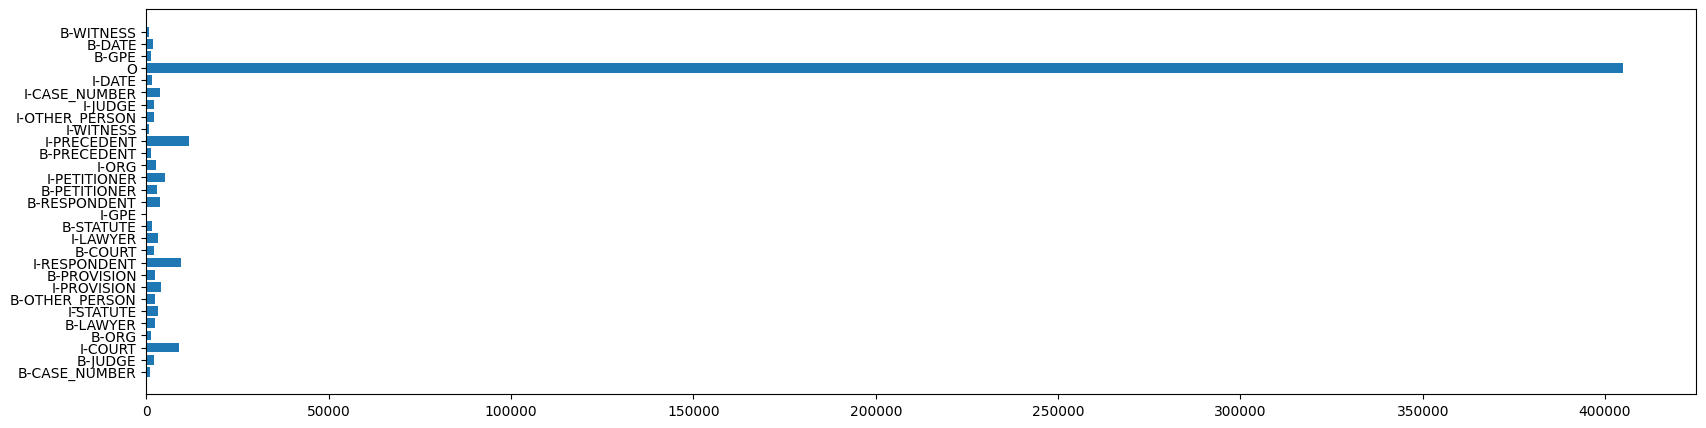

In [27]:
import matplotlib.pyplot as plt
from utils import cast_ner_labels_to_int
from pylab import rcParams
rcParams['figure.figsize'] = 20, 5

X, y = ml_baseline.prepare_dataset(dataset_ner['train'])
casted = cast_ner_labels_to_int(dataset_ner['train'])

class_labels = casted.features['ner_tags'].feature
classes, counts = np.unique(y, return_counts=True)

plt.barh(class_labels.int2str(classes), counts)

### Trying simple multihead attention